# Standalone Driver of DMD Neural Network

## Load modules

In [1]:
import numpy as np
import os

import matplotlib as mpl
mpl.rc('image', cmap='jet')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# %matplotlib inline

from lim_mod_pt import LIM

from read_AM_index_mod import Reanalysis, CMIP6

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch import linalg as la

gpu = 0
device = torch.device('cuda:' + str(gpu) if torch.cuda.is_available() else 'cpu')

# from ode_AM_index_config import hyp_param
# #from ode_AM_index_config import plot_red_noise as plot
# from ode_AM_index_config import LinearFunc, DpTanhFunc, TanhFunc, SoftplusFunc, LeakyReLuFunc

with open("model_list.txt", "r") as f:
    model_list = f.readlines()
    model_list = [d.replace("\n", "") for d in model_list]
# model_list.remove("CESM2")
# model_list.remove("CESM2-WACCM")
# model_list.remove("HadGEM3-GC31-LL")
# model_list.remove("HadGEM3-GC31-MM")
# model_list.remove("KACE")
# model_list.remove("UKESM1")

plev = [1000.,  850.,  700.,  500.,  250.,  100.,   50.,   10.]


## Load data

Reading from saved data ......
JRA55
t.shape = torch.Size([150]), y.shape = torch.Size([56, 150, 8])


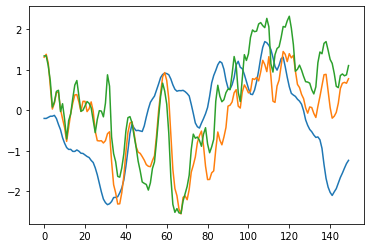

In [2]:
# use plev
D0 = Reanalysis(name_dir='jra_55', year_start=1958, year_end=2014, plev=plev, name='JRA55', \
    annual_cycle_fft=4, running_mean=0, save_index=False)
## use all the levels
# D0 = Reanalysis(name_dir='jra_55', year_start=1958, year_end=2014, name='JRA55', \
#    annual_cycle_fft=4, running_mean=0, save_index=False)

if True:
    # load the AM index
    D0.y, _ = D0.slice_data(month_start=11, len_slice=150, month_start2=8)
    D0.y = torch.from_numpy(D0.y.astype('float32'))
    # D0.y = torch.from_numpy(D0.y.astype('float64'))
    print(D0.name)
    y = D0.y
    t = torch.linspace(0, D0.y.shape[1]-1, D0.y.shape[1], dtype=D0.y.dtype)
    p = D0.level

else:
    # load red noise
    from read_AM_index_mod import get_red_noise

    y = torch.empty((56, 150, 8))
    data_size = y.shape[0]*y.shape[1]
    for n in range(6):
        gamma = [0.06*(n+1)]
        print(1/gamma[0])
        _, yy = get_red_noise(gamma=gamma, data_size=data_size, seed=n*13)
        y[:, :, n] = yy.reshape(y.shape[0], y.shape[1])
    y[:,:,6:] = 0.1*y[:,:,0:2] + 0.9*y[:,:,4:6]
    t = torch.linspace(0, y.shape[1]-1, y.shape[1], dtype=y.dtype)
    p = np.array(plev)

print(f't.shape = {t.shape}, y.shape = {y.shape}')
plt.plot(y[0,:,::3])

## Hyperparameters

In [3]:
# hyperparameters
hyp_param = dict(lim = dict(method = 'DMD',
                            lag_time = 5,
                            eval_time = 20,
                            forecast_time = 40,
                            LIM = dict( r_optimal = None,
                                        ),
                            DMD = dict( r_alpha = 1e-3,
                                        r_ord   = 1,
                                        r_optimal = None,
                                        r_forecast = 5,
                                       )
                            ),

                ode = dict(adjoint = False, # False 
                           method = 'midpoint',
                           options = dict(step_size=0.2),    # step_size for fixed grid ODE solver in unit of t
                           ),
                                       
                data = dict(batch_size = 250, # 100,    # 20, 200, # size of mini-batch
                            batch_time = 5,      # 10,    # the length in 't' integrated by odeint (cf. lag_time in LIM)
                            test_frac = 0.1,     # 0.1,    # fraction of 'dataset' used for test data
                            First_batch_only = False, #False,    # overfit the first batch only for the purpose of debugging
                            ),
                
                train = dict(epochs = 40,   # 40, 20  # number of epochs
                             output_freq = 100,    # output per the number of batches for each epoch
                             lr_scheduler = dict(method = 'StepLR',    # None, 'StepLR', ...
                                                 # if `method = StepLR`, 
                                                 # the learning rate decays by gamma every step_size epochs
                                                 StepLR = dict(step_size=5, gamma=0.5),
                                                ),
                             max_norm = None,    # maximum norm used to clip the norms of model parameters
                             r_alpha = 1e-3,
                             r_ord   = 1,
                            ),     

                # L1 loss is more robust to outliers, but its derivatives are not continuous
                # L2 loss is sensitive to outliers, but gives a more stable and closed form solution
                loss_fn = dict(method = 'MSELoss', # 'MSELoss', 'L1Loss'
                              ),

                # https://ruder.io/optimizing-gradient-descent/
                # RMSprop is an adaptive learning rate algorithm
                # Adam adds bias-correction and momentum to RMSprop.
                optimizer = dict(method = 'RMSprop',     # 'RMSprop', 'Adam', 'SGD'
                                learning_rate = 1e-3,    # 1e-3,    # default LR
                                RMSprop = dict(),
                                Adam = dict(),
                                SGD = dict(momentum=0, weight_decay=0),
                                ),

                func = dict(method = 'Linear', # 'Tanh',
                            size = [y.shape[2], 5, y.shape[2]],
                           ),
                
                )
print(f'hyperpamameters:\n{hyp_param}')

#=======================================================================
batch_size = hyp_param['data']['batch_size']
batch_time = hyp_param['data']['batch_time']
output_freq = hyp_param['train']['output_freq']
alpha = hyp_param['train']['r_alpha']
ord = hyp_param['train']['r_ord']

if hyp_param['ode']['adjoint']:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

hyperpamameters:
{'lim': {'method': 'DMD', 'lag_time': 5, 'eval_time': 20, 'forecast_time': 40, 'LIM': {'r_optimal': None}, 'DMD': {'r_alpha': 0.001, 'r_ord': 1, 'r_optimal': None, 'r_forecast': 5}}, 'ode': {'adjoint': False, 'method': 'midpoint', 'options': {'step_size': 0.2}}, 'data': {'batch_size': 250, 'batch_time': 5, 'test_frac': 0.1, 'First_batch_only': False}, 'train': {'epochs': 40, 'output_freq': 100, 'lr_scheduler': {'method': 'StepLR', 'StepLR': {'step_size': 5, 'gamma': 0.5}}, 'max_norm': None, 'r_alpha': 0.001, 'r_ord': 1}, 'loss_fn': {'method': 'MSELoss'}, 'optimizer': {'method': 'RMSprop', 'learning_rate': 0.001, 'RMSprop': {}, 'Adam': {}, 'SGD': {'momentum': 0, 'weight_decay': 0}}, 'func': {'method': 'Linear', 'size': [8, 5, 8]}}


r_opt=5: % of var=99.941444, B_norm=2.062462, X_err=0.530119, s=1.095610
POP e-folding timescales =
 tensor([23.3919, 23.3919, 10.4264,  7.3009,  4.4967])


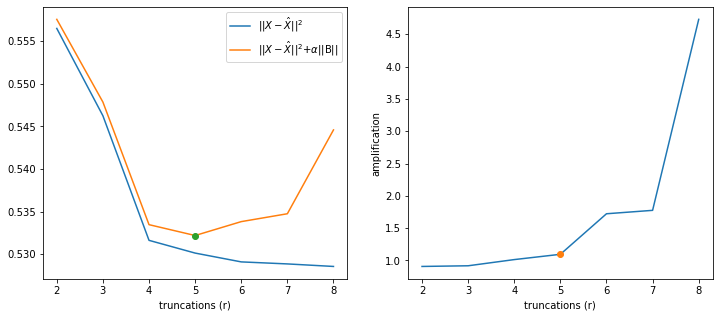

In [4]:
lim = LIM(y, hyp_param, verbose=True)

In [5]:
from ode_mod import get_func, get_loss_fn, get_optimizer

func = get_func(hyp_param['func'], verbose=True)

loss_fn = get_loss_fn(hyp_param['loss_fn'], verbose=True)

optimizer = get_optimizer(func, hyp_param['optimizer'], verbose=True)


func: LinearFunc(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
  )
)
loss_fn = {'method': 'MSELoss'}
optimizer = {'method': 'RMSprop', 'learning_rate': 0.001, 'RMSprop': {}, 'Adam': {}, 'SGD': {'momentum': 0, 'weight_decay': 0}}


r_opt=5: % of var=99.941444, B_norm=2.062462, X_err=0.530119, s=1.095610
POP e-folding timescales =
 tensor([23.3919, 23.3919, 10.4264,  7.3009,  4.4967])


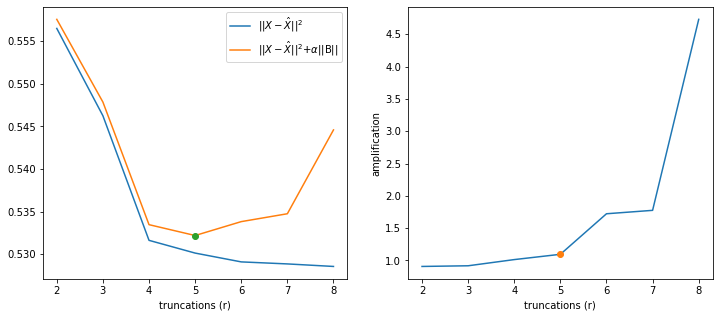

In [6]:
lim = LIM(y, hyp_param, verbose=True)

## Dataloader

In [7]:
len_year, len_day, len_x = y.shape
data_size = len_year*(len_day-batch_time)
n_batch = data_size // batch_size
niters = hyp_param['train']['epochs'] * n_batch

def get_batch():
    # y_idx[data_size, 2]: index for y
    # s[batch_size, 2]: randomly selected index for y
    y_idx = np.array(np.nonzero(np.ones((len_year, len_day-batch_time)))).T
    rng = np.random.default_rng()
    s = torch.from_numpy(rng.choice(y_idx, batch_size, replace=False))

    batch_y0 = y[s[:,0], s[:,1]]
    batch_t = t[:batch_time+1]
    batch_y = torch.vstack([y[s[:,0], s[:,1]+i][None,:] for i in range(batch_time+1)])

    return batch_y0, batch_t, batch_y

batch_y0, batch_t, batch_y = get_batch()
print(f'batch_y0={batch_y0.shape}, batch_t={batch_t.shape}, batch_y={batch_y.shape}')

batch_y0=torch.Size([250, 8]), batch_t=torch.Size([6]), batch_y=torch.Size([6, 250, 8])


## Model

In [8]:
from lim_mod_pt import eig_m

class OdeRun():
    
    def __init__(self):
        self.save = {}
        
    def log(self, key, value, append_value=True):
        if (key in self.save) and append_value:
            self.save[key].append(value)
        else:
            self.save[key] = [value]
    
    def run(self):
        print(f'======= number of iterations: {niters} =======')
        for itr in range(1, niters + 1):
            batch_y0, batch_t, batch_y = get_batch()
            pred_y = odeint(func, batch_y0, batch_t)
            B = func.net(torch.eye(len_x)).T
            loss = loss_fn(pred_y[batch_time,:,:], batch_y[batch_time,:,:]) + alpha*la.vector_norm(B, ord=ord)**ord
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                self.log('loss', loss.item())
                # for name, param in func.named_parameters():
                #     #print(f'{name:} {param.detach().numpy()}')
                #     self.log(name, param.clone().detach().numpy())
                # B = func.net(torch.eye(len_x)).T
                B_norm = (la.vector_norm(B, ord=ord)**ord).item()
                self.log('B_norm', B_norm)
                w, vl, vr = eig_m(B)
                self.log('w', w[0].real)
                self.log('vr', vr[:, 0].real)
                if itr % output_freq == 0:
                    print(f'Iter {itr:>4d} | Loss {loss.item():>8f} | B_norm={B_norm:>8f}')
                    # plot(t, true_y, model=func, lag_time=lag_time)
       
        print(f'======= end of run! =======')

r = OdeRun()
r.run()

======= number of iterations: 1280 =======
Iter  100 | Loss 0.536433 | B_norm=3.475811
Iter  200 | Loss 0.524065 | B_norm=3.271423
Iter  300 | Loss 0.593268 | B_norm=3.105885
Iter  400 | Loss 0.551419 | B_norm=2.932060
Iter  500 | Loss 0.540652 | B_norm=2.768182
Iter  600 | Loss 0.510138 | B_norm=2.645418
Iter  700 | Loss 0.599218 | B_norm=2.623414
Iter  800 | Loss 0.470260 | B_norm=2.570967
Iter  900 | Loss 0.544302 | B_norm=2.517374
Iter 1000 | Loss 0.543168 | B_norm=2.427879
Iter 1100 | Loss 0.522720 | B_norm=2.376497
Iter 1200 | Loss 0.526378 | B_norm=2.319006
======= end of run! =======


## Visualizations

In [9]:
def visualization():

    tt = range(niters)

    fig1 = plt.figure(figsize=(12,10))
    ax1 = fig1.add_subplot(2,2,1)
    X_err = np.array(r.save['loss'])
    ax1.plot(tt, X_err, label='loss')
    ax1.legend()
    # plt.yscale("log")

    ax1 = fig1.add_subplot(2,2,2)
    ax1.plot(tt, np.array(r.save['B_norm']), label='B_norm')
    ax1.legend()

    ax1 = fig1.add_subplot(2,2,3)
    ax1.plot(tt, np.array(r.save['w']), label='w')
    ax1.legend()

    # ax1 = fig1.add_subplot(2,2,4)
    # ax1.contourf(tt, p, -1/np.array(r.save['vr']))
    # ax1.legend()

    print(f"\nB_norm[-1]={r.save['B_norm'][-1]}, err[-1]={X_err[-1]}")

    print(f'r.save.keys: {r.save.keys()}\n')


def visualization2():

    from lim_mod_pt import eig_m
    with torch.no_grad():
        B = func.net(torch.eye(len_x)).T
        # print(torch.norm(B), r.save['B_norm'][-1])
    w, vl, vr = eig_m(B)
    print(f"e-folding timescales =\n {-1/w.real}\nB={B}\n")

    mm = 0
    fig = plt.figure(figsize=(12,5))
    fig.add_subplot(1, 2, 1)
    sn = np.sign(vr[np.isin(p, 10), mm].real)
    plt.plot(vr[:, mm].real*sn, p, label='NN')
    sn = np.sign(lim.vr[np.isin(p, 10), 0].real)
    plt.plot(lim.vr[:, 0].real*sn, p, label='LIM')

    plt.gca().invert_yaxis()
    plt.ylabel('Pressure (hPa)')
    plt.yscale('log')
    plt.yticks([10, 30, 100, 300, 1000])
    plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
    plt.legend()

    cmax = 0.15
    fig = plt.figure(figsize=(12, 5))
    fig.add_subplot(1, 2, 1)
    plt.contourf(B.numpy(), np.linspace(-cmax, cmax, 11))
    cbar = plt.colorbar()
    cbar.set_ticks(np.linspace(-cmax, cmax, 11))
    plt.title('NN')

    fig.add_subplot(1, 2, 2)
    plt.contourf(lim.B.real, np.linspace(-cmax, cmax, 11))
    cbar = plt.colorbar()
    cbar.set_ticks(np.linspace(-cmax, cmax, 11))
    plt.title('LIM')


def visualization3():
    with torch.no_grad():
        B = func.net(torch.eye(len_x)).T
        yf = torch.empty((len_year, batch_time+1, len_day-batch_time, len_x))
        yf_lim = torch.empty_like(yf) 

        for n in range(len(y)):
            yf[n] = odeint(func, y[n, :-batch_time], batch_t)
            yf_lim[n] = lim.forecast(y[n, :-batch_time], batch_t)

        # X_err = 0
        # X_err_lim = 0
        # for n in range(batch_time+1):
        #     X_err += torch.norm(y[:, n:n+len_day-batch_time,:] - yf[:, n, :, :])**2.0
        #     X_err_lim += torch.norm(y[:, n:n+len_day-batch_time,:] - yf_lim[:, n, :, :])**2.0
        # X_err /= yf.numel()
        # X_err_lim /= yf.numel()

        X_err = la.norm(y[:, batch_time:, :] - yf[:, batch_time, :, :])**2.0/(yf.shape[0]*yf.shape[2]*yf.shape[3])
        X_err_lim = la.norm(y[:, batch_time:, :] - yf_lim[:, batch_time, :, :])**2.0/(yf.shape[0]*yf.shape[2]*yf.shape[3])
    
    print(f'y={y.shape}, yf={yf.shape}, yf_lim={yf_lim.shape}')

    print(f'(All data) NN: B_norm={la.vector_norm(B, ord=ord)**ord}, err={X_err}\n LIM: B_norm={la.vector_norm(lim.B, ord=ord)**ord}, err={X_err_lim}')

## Test 1

hyperpamameters:
{'lim': {'method': 'DMD', 'lag_time': 5, 'eval_time': 20, 'forecast_time': 40, 'LIM': {'r_optimal': None}, 'DMD': {'r_alpha': 0.001, 'r_ord': 1, 'r_optimal': None, 'r_forecast': 5}}, 'ode': {'adjoint': False, 'method': 'midpoint', 'options': {'step_size': 0.2}}, 'data': {'batch_size': 250, 'batch_time': 5, 'test_frac': 0.1, 'First_batch_only': False}, 'train': {'epochs': 40, 'output_freq': 100, 'lr_scheduler': {'method': 'StepLR', 'StepLR': {'step_size': 5, 'gamma': 0.5}}, 'max_norm': None, 'r_alpha': 0.001, 'r_ord': 1}, 'loss_fn': {'method': 'MSELoss'}, 'optimizer': {'method': 'RMSprop', 'learning_rate': 0.001, 'RMSprop': {}, 'Adam': {}, 'SGD': {'momentum': 0, 'weight_decay': 0}}, 'func': {'method': 'Linear', 'size': [8, 5, 8]}}

B_norm[-1]=2.248297929763794, err[-1]=0.5394641160964966
r.save.keys: dict_keys(['loss', 'B_norm', 'w', 'vr'])

e-folding timescales =
 tensor([-43.5840,  63.0985,  63.0985,  19.9303,  14.6611,   8.2563,   6.1965,
          5.4442])
B=tensor(

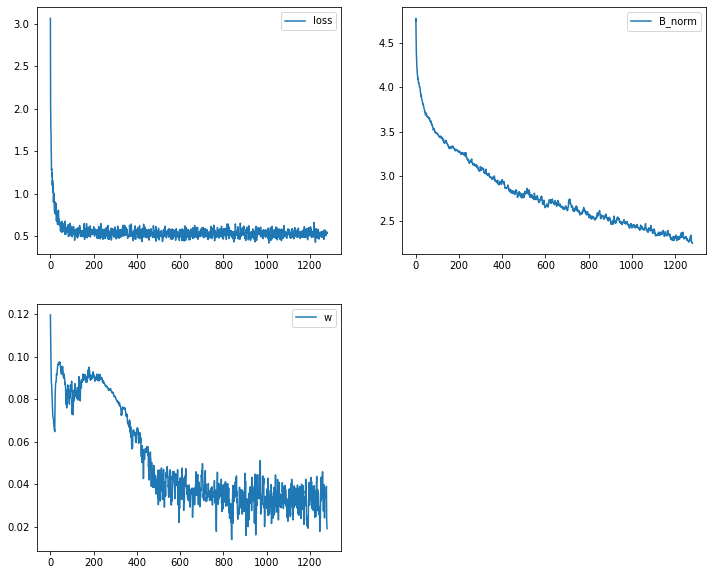

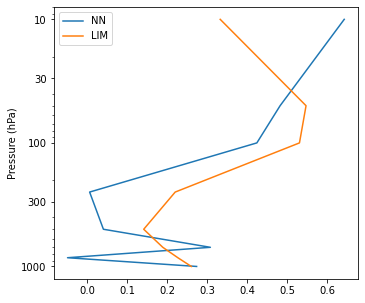

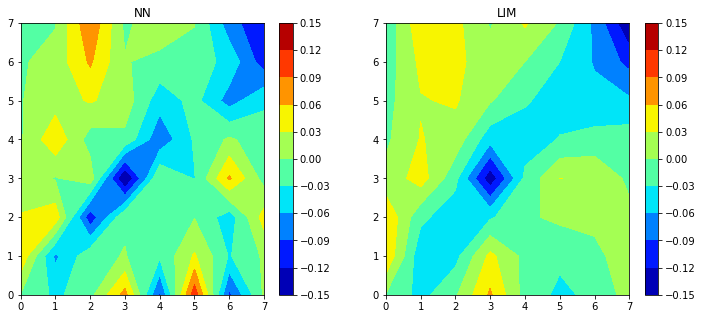

In [10]:
print(f'hyperpamameters:\n{hyp_param}')

visualization()

visualization2()

visualization3()

## Test 2

hyperpamameters:
{'lim': {'method': 'DMD', 'lag_time': 5, 'eval_time': 20, 'forecast_time': 40, 'LIM': {'r_optimal': None}, 'DMD': {'r_alpha': 0.001, 'r_ord': 1, 'r_optimal': None, 'r_forecast': 5}}, 'ode': {'adjoint': False, 'method': 'midpoint', 'options': {'step_size': 0.2}}, 'data': {'batch_size': 250, 'batch_time': 5, 'test_frac': 0.1, 'First_batch_only': False}, 'train': {'epochs': 40, 'output_freq': 100, 'lr_scheduler': {'method': 'StepLR', 'StepLR': {'step_size': 5, 'gamma': 0.5}}, 'max_norm': None, 'r_alpha': 0.001, 'r_ord': 1}, 'loss_fn': {'method': 'MSELoss'}, 'optimizer': {'method': 'RMSprop', 'learning_rate': 0.001, 'RMSprop': {}, 'Adam': {}, 'SGD': {'momentum': 0, 'weight_decay': 0}}, 'func': {'method': 'Linear', 'size': [8, 5, 8]}}

B_norm[-1]=2.248297929763794, err[-1]=0.5394641160964966
r.save.keys: dict_keys(['loss', 'B_norm', 'w', 'vr'])

e-folding timescales =
 tensor([-43.5840,  63.0985,  63.0985,  19.9303,  14.6611,   8.2563,   6.1965,
          5.4442])
B=tensor(

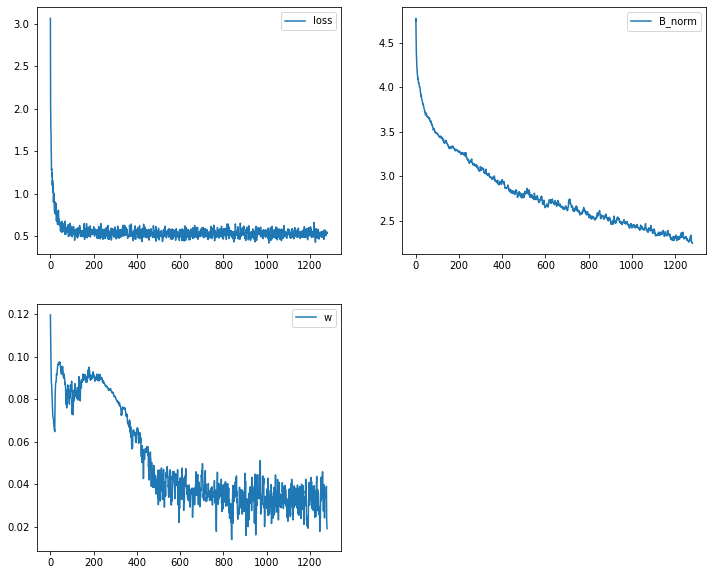

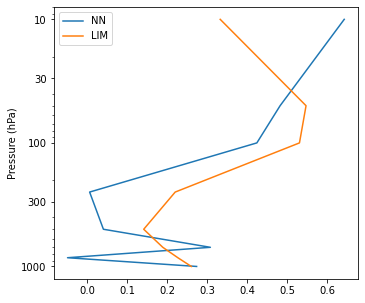

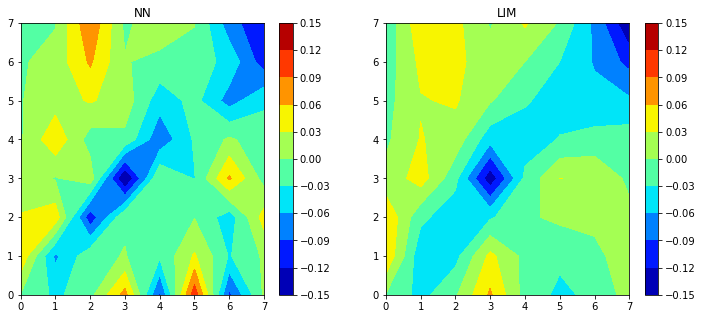

In [11]:
print(f'hyperpamameters:\n{hyp_param}')

visualization()

visualization2()

visualization3()

## Test 3

hyperpamameters:
{'lim': {'method': 'DMD', 'lag_time': 5, 'eval_time': 20, 'forecast_time': 40, 'LIM': {'r_optimal': None}, 'DMD': {'r_alpha': 0.001, 'r_ord': 1, 'r_optimal': None, 'r_forecast': 5}}, 'ode': {'adjoint': False, 'method': 'midpoint', 'options': {'step_size': 0.2}}, 'data': {'batch_size': 250, 'batch_time': 5, 'test_frac': 0.1, 'First_batch_only': False}, 'train': {'epochs': 40, 'output_freq': 100, 'lr_scheduler': {'method': 'StepLR', 'StepLR': {'step_size': 5, 'gamma': 0.5}}, 'max_norm': None, 'r_alpha': 0.001, 'r_ord': 1}, 'loss_fn': {'method': 'MSELoss'}, 'optimizer': {'method': 'RMSprop', 'learning_rate': 0.001, 'RMSprop': {}, 'Adam': {}, 'SGD': {'momentum': 0, 'weight_decay': 0}}, 'func': {'method': 'Linear', 'size': [8, 5, 8]}}

B_norm[-1]=2.248297929763794, err[-1]=0.5394641160964966
r.save.keys: dict_keys(['loss', 'B_norm', 'w', 'vr'])

e-folding timescales =
 tensor([-43.5840,  63.0985,  63.0985,  19.9303,  14.6611,   8.2563,   6.1965,
          5.4442])
B=tensor(

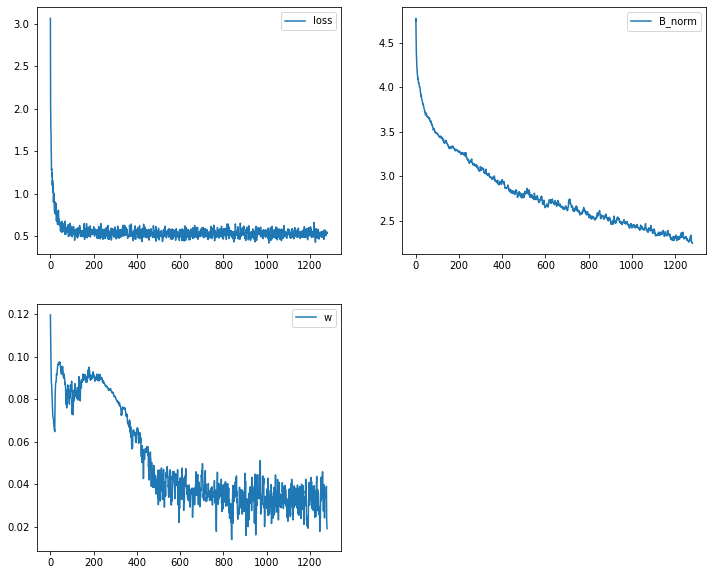

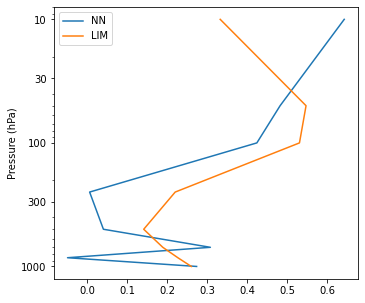

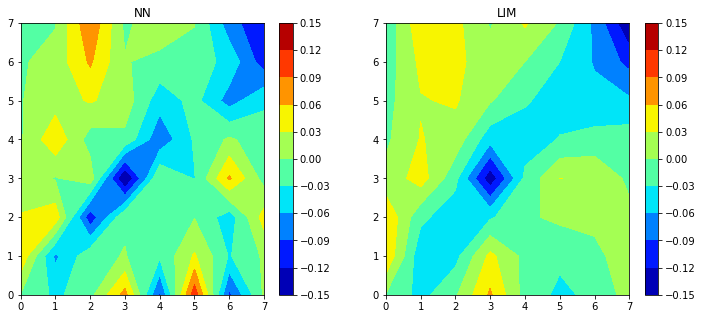

In [12]:
print(f'hyperpamameters:\n{hyp_param}')

visualization()

visualization2()

visualization3()